# Introduction

Team Members:
    
    Robin Paul
    Saurabh Jain

## Goals

In the “genomics era” where the cost of sequencing entire genomes of individual persons has gone substantially low (~1000$), this has given rise to the idea of “personalized medicine” where treatment of a cancer patient can be given according to the genetic makeup of the patient. According to the central dogma of life, the genome contains all the important information pertaining to life which is encoded in DNA. For specific biological processes, relevant genes are transcribed into RNA which in turn is expressed into proteins for carrying out vital functions of the body. During cancer progression, certain biological processes are carried out by the tumor cell which is different from normal healthy cells. By studying the RNA transcription pattern of genes in individual patients we can correlate genotype (e.g. RNA expression pattern) of patients with patient phenotypes (e.g. histological type, age). 
In this project we plan to use a publicly available data for breast cancer patients available in Kaggle. This dataset contains proteome profiling of 77 breast cancer patients. We want to correlate the expression values for 12553 genes for each of these patients with their histological type (ER-positive, PR-positive and TNBC). We also want to study which genes are the most important for categorizing a breast cancer patient into various subtypes.

Sub-goals:

    Unsupervised learning to find optimal clusters
    
    PCA analysis to find most releavnt genes to identify cancer type

## Datasets

Context: This data set contains published iTRAQ proteome profiling of 80 breast cancer samples generated by the Clinical Proteomic Tumor Analysis Consortium (NCI/NIH). It contains expression values for 12,553 proteins for each sample, with missing values present when a given protein could not be quantified in a given sample.

Content:

File: 77_cancer_proteomes_CPTAC_itraq.csv

RefSeq_accession_number: RefSeq protein ID (each protein has a unique ID in a RefSeq database)
gene_symbol: a symbol unique to each gene (every protein is encoded by some gene)
gene_name: a full name of that gene Remaining columns: log2 iTRAQ ratios for each sample (protein expression data, most important), three last columns are from healthy individuals
File: clinical_data_breast_cancer.csv

First column "Complete TCGA ID" is used to match the sample IDs in the main cancer proteomes file (see example script). All other columns have self-explanatory names, contain data about the cancer classification of a given sample using different methods. 'PAM50 mRNA' classification is being used in the example script.

File: PAM50_proteins.csv

Contains the list of genes and proteins used by the PAM50 classification system. The column RefSeqProteinID contains the protein IDs that can be matched with the IDs in the main protein expression data set.

In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import metrics
import re
from sklearn.preprocessing import Imputer
from numpy import random
import seaborn as sb
import matplotlib.pyplot as plt 
import time
import numpy as np

In [2]:
### Set path to the data set
dataset_path = "77_cancer_proteomes_CPTAC_itraq.csv"
clinical_info = "clinical_data_breast_cancer.csv"
clinical_info_type = "TCGApattype.txt"
pam50_proteins = "PAM50_proteins.csv"

In [3]:
## Load data
data = pd.read_csv(dataset_path,header=0,index_col=0)
clinical = pd.read_csv(clinical_info,header=0,index_col=0)## holds clinical information about each patient/sample
clinical_type = pd.read_csv(clinical_info_type,sep="\t",header=0,index_col=0)## holds clinical information about each patient/sample
pam50 = pd.read_csv(pam50_proteins,header=0)

### Breast cancer patient protein expression dataset.

In [4]:
data.head()

,gene_symbol,gene_name,AO-A12D.01TCGA,C8-A131.01TCGA,AO-A12B.01TCGA,BH-A18Q.02TCGA,C8-A130.02TCGA,C8-A138.03TCGA,E2-A154.03TCGA,C8-A12L.04TCGA,...,AO-A12B.34TCGA,A2-A0SW.35TCGA,AO-A0JL.35TCGA,BH-A0BV.35TCGA,A2-A0YM.36TCGA,BH-A0C7.36TCGA,A2-A0SX.36TCGA,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
RefSeq_accession_number,,,,,,,,,,,,,,,,,,,,,
NP_958782,PLEC,plectin isoform 1,1.096131,2.609943,-0.659828,0.195341,-0.494060,2.765081,0.862659,1.407570,...,-0.963904,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.398560,0.598585,-0.191285,0.566975
NP_958785,NaN,plectin isoform 1g,1.111370,2.650422,-0.648742,0.215413,-0.503899,2.779709,0.870186,1.407570,...,-0.938210,-0.487772,-0.10668,-0.055893,0.658143,-0.547749,-0.392601,0.606697,-0.183918,0.578702
NP_958786,PLEC,plectin isoform 1a,1.111370,2.650422,-0.654285,0.215413,-0.500619,2.779709,0.870186,1.410312,...,-0.943919,-0.487772,-0.10668,-0.065838,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_000436,NaN,plectin isoform 1c,1.107561,2.646374,-0.632113,0.205377,-0.510459,2.797995,0.866423,1.407570,...,-0.935355,-0.487772,-0.10668,-0.055893,0.655850,-0.552212,-0.392601,0.603993,-0.186022,0.576747
NP_958781,NaN,plectin isoform 1e,1.115180,2.646374,-0.640428,0.215413,-0.503899,2.787023,0.870186,1.413053,...,-0.935355,-0.503853,-0.10668,-0.062523,0.651264,-0.556675,-0.395581,0.603993,-0.167079,0.576747


In this dataset, in the 1st column the protein ID's for each of the proteins are give. The 2nd and the 3rd columns contains their gene name and their coreesponding biological functions. The following columns contain the expression value for each of those proteins for a particular breast cancer patient. 

In [5]:
data.describe()

,AO-A12D.01TCGA,C8-A131.01TCGA,AO-A12B.01TCGA,BH-A18Q.02TCGA,C8-A130.02TCGA,C8-A138.03TCGA,E2-A154.03TCGA,C8-A12L.04TCGA,A2-A0EX.04TCGA,AO-A12D.05TCGA,...,AO-A12B.34TCGA,A2-A0SW.35TCGA,AO-A0JL.35TCGA,BH-A0BV.35TCGA,A2-A0YM.36TCGA,BH-A0C7.36TCGA,A2-A0SX.36TCGA,263d3f-I.CPTAC,blcdb9-I.CPTAC,c4155b-C.CPTAC
count,11334.000000,11335.000000,11334.000000,12024.000000,12025.000000,11833.000000,11833.000000,11732.000000,11732.000000,11276.000000,...,11477.000000,10324.000000,10324.000000,10324.000000,9694.000000,9693.000000,9697.000000,10912.000000,10885.000000,10913.000000
mean,0.133079,0.128822,-0.440764,-0.729233,-0.039436,0.115353,-0.618354,-0.305320,-0.021228,0.077247,...,-0.677085,-0.103215,-0.021222,-0.100912,0.488502,-0.368762,-0.050669,0.069555,-0.298170,0.310974
std,1.734231,1.579845,1.634930,2.422452,1.353505,1.652918,2.281818,1.567687,1.651917,1.749695,...,2.018394,1.570606,1.656519,1.628017,1.658080,1.453737,1.716237,1.950822,1.307027,1.706759
min,-12.466750,-13.156553,-9.911008,-24.553794,-15.004199,-12.956961,-16.640848,-18.710032,-14.711526,-13.441463,...,-12.497832,-12.152747,-11.874381,-11.128835,-8.772601,-10.427946,-12.967849,-12.609296,-9.058864,-6.328154
25%,-0.656376,-0.583835,-1.330525,-1.266591,-0.671173,-0.679944,-1.278707,-0.991299,-0.718023,-0.728075,...,-1.731881,-0.815820,-0.740905,-0.805968,-0.497485,-1.063180,-0.934818,-0.867155,-1.056363,-0.652571
50%,0.078915,0.116448,-0.318937,-0.296430,0.024160,0.088055,-0.157218,-0.231885,0.037039,0.045209,...,-0.444306,-0.056808,0.023619,-0.037659,0.314206,-0.204129,-0.079784,0.052313,-0.191285,0.137007
75%,0.905641,0.853163,0.489641,0.449590,0.719492,0.929197,0.670727,0.483663,0.750830,0.862472,...,0.500677,0.657177,0.800701,0.714075,1.276655,0.521043,0.757374,1.009641,0.574868,1.059485
max,17.623036,12.677023,8.289261,11.790434,6.925004,10.602330,10.079191,8.804312,9.548006,13.066445,...,8.839935,10.694780,11.309371,12.638208,11.164262,7.886564,11.521261,16.183559,6.435721,10.497291


This contains the statistical overview (containing median, standard deviation and quantile information) of the protein expression for each of the breast cancer patients.

### Breast cancer subtype dataset

In [6]:
filename1="TCGApattype.txt"

patientId=[]
pattype=[]
for line in open(filename1,'r'):
   line2=line.split("\t")
   pat=line2[0].split("-") 
   try: 
      patientId.append(pat[1]+"-"+pat[2])
      pattype.append(line2[1].replace("\n",""))  
   except IndexError:
      pass
patientId=np.array(patientId)
print ("Unique labels:",list(set(pattype)))

Unique labels: ['Undetermined', 'TNBC', 'ER/PR-Positive', 'HER2-Positive']


This file contains the ground truth of each of the patients i.e the breast cancer subtype of each of the patients. There are three subtypes of breast cancer: ER/PR-Positive, HER2-Positive and TNBC.

In [7]:
clinical.head()

,Gender,Age at Initial Pathologic Diagnosis,ER Status,PR Status,HER2 Final Status,Tumor,Tumor--T1 Coded,Node,Node-Coded,Metastasis,...,PAM50 mRNA,SigClust Unsupervised mRNA,SigClust Intrinsic mRNA,miRNA Clusters,methylation Clusters,RPPA Clusters,CN Clusters,Integrated Clusters (with PAM50),Integrated Clusters (no exp),Integrated Clusters (unsup exp)
Complete TCGA ID,,,,,,,,,,,,,,,,,,,,,
TCGA-A2-A0T2,FEMALE,66,Negative,Negative,Negative,T3,T_Other,N3,Positive,M1,...,Basal-like,0,-13,3,5,Basal,3,2,2,2
TCGA-A2-A0CM,FEMALE,40,Negative,Negative,Negative,T2,T_Other,N0,Negative,M0,...,Basal-like,-12,-13,4,4,Basal,4,2,1,1
TCGA-BH-A18V,FEMALE,48,Negative,Negative,Negative,T2,T_Other,N1,Positive,M0,...,Basal-like,-12,-13,5,5,Basal,1,2,2,2
TCGA-BH-A18Q,FEMALE,56,Negative,Negative,Negative,T2,T_Other,N1,Positive,M0,...,Basal-like,-12,-13,5,5,Basal,1,2,2,2
TCGA-BH-A0E0,FEMALE,38,Negative,Negative,Negative,T3,T_Other,N3,Positive,M0,...,Basal-like,0,-13,5,5,Basal,1,2,2,2


### The PAM50 validation dataset

In [8]:
pam50.head()

,GeneSymbol,RefSeqProteinID,Species,Gene Name
0,MIA,NP_006524,Homo sapiens,melanoma inhibitory activity
1,FGFR4,NP_002002,Homo sapiens,fibroblast growth factor receptor 4
2,FGFR4,NP_998812,Homo sapiens,fibroblast growth factor receptor 4
3,FGFR4,NP_075252,Homo sapiens,fibroblast growth factor receptor 4
4,GPR160,NP_055188,Homo sapiens,G protein-coupled receptor 160


The [PAM50](https://www.nature.com/articles/npjbcancer201523) are a set of proteins whose expression signature have been [previously](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3487945/figure/F1/) shown to have been able to classify different subtypes of breast cancer. Therefore, this dataset can be used as a baseline to check the efficiency of feature selection.

In [9]:
pam50.describe()

,GeneSymbol,RefSeqProteinID,Species,Gene Name
count,100,100,100,100
unique,50,100,1,50
top,MDM2,NP_005219,Homo sapiens,Mdm2 p53 binding protein homolog (mouse)
freq,9,1,100,9


## Tasks completed

Tasks done:
    
    Phase 1
    
    Data download, Data loading [Saurabh, Robin]
    Pre processing [Saurabh]
    Baseline Kmeans for clustering [Saurabh]
    Cluserting using AffinityPropogation [Saurabh]
    Clustering using DBSACN [Saurabh]
    Time optimization using Mini Batch [Saurabh]
    Clustering using principal component analysis [Robin]
    Define purity for each cluster [Robin]
    
    
    Phase 2
    
    Using GRID Search to find optimal values for hyper pamameters [3.1] [Saurabh]
    Using Random Search to use and find optimal values for hyper pamameters [3.2] [Saurabh]
    Using GRID Search to find metrics when increasing the search for cluster size [Saurabh]
    Added table for each of the various cases tried for clustering to show parameters as Algorithm used, Num of clusters,  n_init, max_iter, Silhouette Coefficient, Homogeneity score, Train Time(s) [Saurabh]
    Predicting number of clusters on the original cleaned dataset using PCA [Robin]
    Feature selection of proteins for breast cancer subtype prediction using Lasso penalization [Robin]
    Predicting number of clusters on the Lasso penalized regularized dataset using PCA [Robin]
    Calculating purity of the three breast cancer subtypes for the Lasso panalized dataset [Robin]
    
    Phase 3
    
    Evaluation Metrics for Unsupervised Learning [Section 2.2] [Saurabh]
    Discussion for Unsupervised learning [2.8] [Saurabh]
    Discussion for GRID/Random Search and Hyper parameter tuning for unsupervsed learning [3.4] [Saurabh]
    Incorporated Pipelines for Unsupervised learning [2.4] [Saurabh]
    Other imputing strategies such as Scaler and Normalizer [2.4] [Saurabh]
    Elbow method using inertia graph [2.3, 2,4, 2.5] [Saurabh]
    Success failure analysis [4] [Robin]
    Calculating number of proteins common in the L1 penalized dataset with the baseline PAM50 dataset [Robin]
    Calculating the statistical significance of the number of common proteins to test the efficiency of the L1 penalization selection [Robin]
    Gaussian Mixture Models [4.4] [Saurabh]
    GMM with PCA [Robin]
    
    Phase 4
    
    Video [Robin, Saurabh]
    Dendogram [Saurabh]
    Report [Robin, Saurabh]
    

# Phase 1 - Evaluation metrics

In [10]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import metrics
import re
from sklearn.preprocessing import Imputer
from numpy import random
import seaborn as sb
import matplotlib.pyplot as plt 
import time

## Pre-processing

In [11]:
## Drop unused information columns
data.drop(['gene_symbol','gene_name'],axis=1,inplace=True) 
 
## Change the protein data sample names to a format matching the clinical data set
data.rename(columns=lambda x: "TCGA-%s" % (re.split('[_|-|.]',x)[0]) if bool(re.search("TCGA",x)) is True else x,inplace=True)
 
## Transpose data for the clustering algorithm since we want to divide patient samples, not proteins
data = data.transpose()
 
## Drop clinical entries for samples not in our protein data set
clinical = clinical.loc[[x for x in clinical.index.tolist() if x in data.index],:]

In [12]:
## Add clinical meta data to our protein data set, note: all numerical features for analysis start with NP_ or XP_
merged = data.merge(clinical,left_index=True,right_index=True)

processed = merged
 
## Numerical data for the algorithm, NP_xx/XP_xx are protein identifiers from RefSeq database
processed_numerical = processed.loc[:,[x for x in processed.columns if bool(re.search("NP_|XP_",x)) == True]]
 
## Select only the PAM50 proteins - known panel of genes used for breast cancer subtype prediction
processed_numerical_p50 = processed_numerical.ix[:,processed_numerical.columns.isin(pam50['RefSeqProteinID'])]

C:\Users\LENOVO\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # Remove the CWD from sys.path while we load stuff.


In [13]:
## Impute missing values 
imputer = Imputer(missing_values='NaN', strategy='median', axis=1)
imputer = imputer.fit(processed_numerical_p50)
processed_numerical_p50_original = processed_numerical_p50
processed_numerical_p50 = imputer.transform(processed_numerical_p50)
processed_numerical_p50_copy = processed_numerical_p50

In [14]:
processed_numerical_p50

array([[ 2.16015744,  2.62302061,  4.76835465, ...,  2.51648861,
         2.5568973 ,  0.89646753],
       [ 2.24970172,  3.57694103,  2.16986778, ...,  3.48712784,
         0.87090299, -0.71413343],
       [-0.0209573 ,  1.88493566, -7.40724933, ...,  0.79804088,
         2.00357559, -0.5280473 ],
       ..., 
       [-2.74266425, -3.30717211, -5.90390825, ...,  0.39599944,
        -3.96200122, -7.80441803],
       [-0.78177666, -1.58847422, -3.73294524, ..., -0.91286501,
         3.24050703, -2.09041937],
       [ 0.22965842, -0.44137307, -1.18398126, ..., -0.53979102,
         1.85802818, -4.31546156]])

In [15]:
import pandas as pd

results = pd.DataFrame(columns=["Algorithm", "n_clusters", "n_init", "max_iter", "Silhouette Coefficient" , "Homogeneity score", "Train Time(s)"])



## Evaluation Metrics for Unsupervised Learning

The evaluation metrics for unsupervised clustering learning are very different as agaisnt supervised learning. Here we are working on the clustering problem and hence we choose following three evaluation metrics 

-  Silhouette score

    The Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b)

    The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters
    

-  Homogeneity score

    A clustering result satisfies homogeneity if all of its clusters contain only data points which are members of a single class.

    Have positive values between 0.0 and 1.0, larger values being desirable.
    

-  Inertia

    Sum of squared distances of samples to their closest cluster center.

    Also referred as within-cluster sum of squares criterion, can be recognized as a measure of how internally coherent clusters are.


## Kmeans

In [16]:
## Check which number of clusters works best
n_clusters = [2,3,4,5,6,7,8,10,20]
inertias = []
 
def compare_k_means(k_list,data):
    inertias = []
    ## Run clustering with different k and check the metrics
    for k in k_list:
        clusterer = KMeans(n_clusters=k, n_jobs=4)
        clusterer.fit(data)
        #print(clusterer.labels_)
        #print(len(clusterer.labels_))
        ## The higher (up to 1) the better
        print("Silhouette Coefficient for k == %s: %s" % (
        k, round(metrics.silhouette_score(data, clusterer.labels_), 4)))
        ## The higher (up to 1) the better
        print("Homogeneity score for k == %s: %s" % (
        k, round(metrics.homogeneity_score(processed['PAM50 mRNA'], clusterer.labels_),4)))
        print("------------------------")
        inertias.append(clusterer.inertia_)
    
    # Plot ks vs inertias
    plt.plot(k_list, inertias, '-o')
    plt.xlabel('number of clusters, k')
    plt.ylabel('inertia')
    plt.xticks(k_list)
    plt.show()

In [17]:
## What if we use a random set of 43 proteins
## Create a random numerical matrix with imputation:
processed_numerical_random = processed_numerical.iloc[:,random.choice(range(processed_numerical.shape[1]),43)]
imputer_rnd = imputer.fit(processed_numerical_random)
processed_numerical_random = imputer_rnd.transform(processed_numerical_random)

Silhouette Coefficient for k == 2: 0.2077
Homogeneity score for k == 2: 0.2073
------------------------
Silhouette Coefficient for k == 3: 0.1736
Homogeneity score for k == 3: 0.4138
------------------------
Silhouette Coefficient for k == 4: 0.1397
Homogeneity score for k == 4: 0.428
------------------------
Silhouette Coefficient for k == 5: 0.1417
Homogeneity score for k == 5: 0.4767
------------------------
Silhouette Coefficient for k == 6: 0.1153
Homogeneity score for k == 6: 0.5421
------------------------
Silhouette Coefficient for k == 7: 0.1207
Homogeneity score for k == 7: 0.5283
------------------------
Silhouette Coefficient for k == 8: 0.0989
Homogeneity score for k == 8: 0.4819
------------------------
Silhouette Coefficient for k == 10: 0.0919
Homogeneity score for k == 10: 0.5692
------------------------
Silhouette Coefficient for k == 20: 0.0788
Homogeneity score for k == 20: 0.6959
------------------------


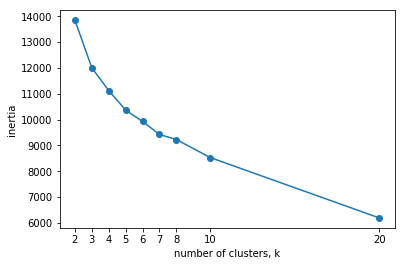

In [18]:
## Check different numbers of clusters for the PAM50 proteins, there are 4 subtypes of cancer in this data
## 3 samples of healthy patients were dropped at the beginning...
compare_k_means(n_clusters,processed_numerical_p50)
## seems that k==3 works good, the silhouette score is still high and the homogeneity score jumps ~2-fold

**This plot suggests us that optimal value of clusters 3 or 4, after which there is relatively less drop in inertia. Choosing 3 as number of desired clusters**

In [19]:
clusterer_final = KMeans(n_clusters=3, n_jobs=4)
clusterer_final = clusterer_final.fit(processed_numerical_p50)

score_sil = round(metrics.silhouette_score(processed_numerical_p50, clusterer_final.labels_), 4)
print(score_sil)

score_homegenity = round(metrics.homogeneity_score(processed['PAM50 mRNA'], clusterer_final.labels_),4)
print(score_homegenity)

0.1705
0.4021


In [20]:
results.loc[len(results)] = ["K Means Default", 
                             3, 
                             "10",
                             "300",
                             score_sil,
                             score_homegenity,
                             ""]

results

,Algorithm,n_clusters,n_init,max_iter,Silhouette Coefficient,Homogeneity score,Train Time(s)
0,K Means Default,3,10,300,0.1705,0.4021,


Silhouette Coefficient for k == 2: 0.2595
Homogeneity score for k == 2: 0.0054
------------------------
Silhouette Coefficient for k == 3: 0.1136
Homogeneity score for k == 3: 0.0598
------------------------
Silhouette Coefficient for k == 4: 0.0932
Homogeneity score for k == 4: 0.1329
------------------------
Silhouette Coefficient for k == 5: 0.0858
Homogeneity score for k == 5: 0.2027
------------------------
Silhouette Coefficient for k == 6: 0.0744
Homogeneity score for k == 6: 0.2788
------------------------
Silhouette Coefficient for k == 7: 0.0765
Homogeneity score for k == 7: 0.1713
------------------------
Silhouette Coefficient for k == 8: 0.072
Homogeneity score for k == 8: 0.1603
------------------------
Silhouette Coefficient for k == 10: 0.0575
Homogeneity score for k == 10: 0.2072
------------------------
Silhouette Coefficient for k == 20: 0.0681
Homogeneity score for k == 20: 0.3837
------------------------


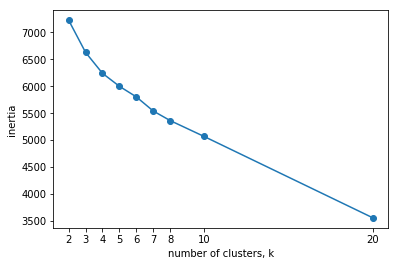

In [21]:
## Use random proteins for comparison
compare_k_means(n_clusters,processed_numerical_random)


**We clearly see that both Silhouette Coefficient and Homogeneity score are low when we choose random proteins for comparision**

In [22]:
clusterer_final = KMeans(n_clusters=3, n_jobs=4)
clusterer_final = clusterer_final.fit(processed_numerical_random)

score_sil = round(metrics.silhouette_score(processed_numerical_random, clusterer_final.labels_), 4)
print(score_sil)

score_homegenity = round(metrics.homogeneity_score(processed['PAM50 mRNA'], clusterer_final.labels_),4)
print(score_homegenity)

0.1066
0.0391


In [23]:
results.loc[len(results)] = ["K Means Default Random protein", 
                             3, 
                             "10",
                             "300",
                             score_sil,
                             score_homegenity,
                             ""]

results

,Algorithm,n_clusters,n_init,max_iter,Silhouette Coefficient,Homogeneity score,Train Time(s)
0,K Means Default,3,10,300,0.1705,0.4021,
1,K Means Default Random protein,3,10,300,0.1066,0.0391,


In [24]:
## Visualize data using k==3, show the heatmap of protein expression for the used PAM50 proteins
clusterer_final = KMeans(n_clusters=3, n_jobs=4)
t0 = time.time()
#k_means.fit(X)
clusterer_final = clusterer_final.fit(processed_numerical_p50)
t_batch = time.time() - t0


processed_p50_plot = pd.DataFrame(processed_numerical_p50)
processed_p50_plot['KMeans_cluster'] = clusterer_final.labels_
processed_p50_plot.sort_values('KMeans_cluster',axis=0,inplace=True)



In [25]:
score_sil = round(metrics.silhouette_score(processed_numerical_p50, clusterer_final.labels_), 4)
print(score_sil)

score_homegenity = round(metrics.homogeneity_score(processed['PAM50 mRNA'], clusterer_final.labels_),4)
print(score_homegenity)

0.1753
0.4125


In [26]:
print("Time taken to fit : %0.3f s" % (t_batch))

Time taken to fit : 1.819 s


In [27]:
results.loc[len(results)] = ["K Means Default with time", 
                             3, 
                             "10",
                             "300",
                             score_sil,
                             score_homegenity,
                             "%0.3f s" % (t_batch)]

results

,Algorithm,n_clusters,n_init,max_iter,Silhouette Coefficient,Homogeneity score,Train Time(s)
0,K Means Default,3,10,300,0.1705,0.4021,
1,K Means Default Random protein,3,10,300,0.1066,0.0391,
2,K Means Default with time,3,10,300,0.1753,0.4125,1.819 s


**Total time taken by default K means for extrcating 3 clusters is 1.317s**

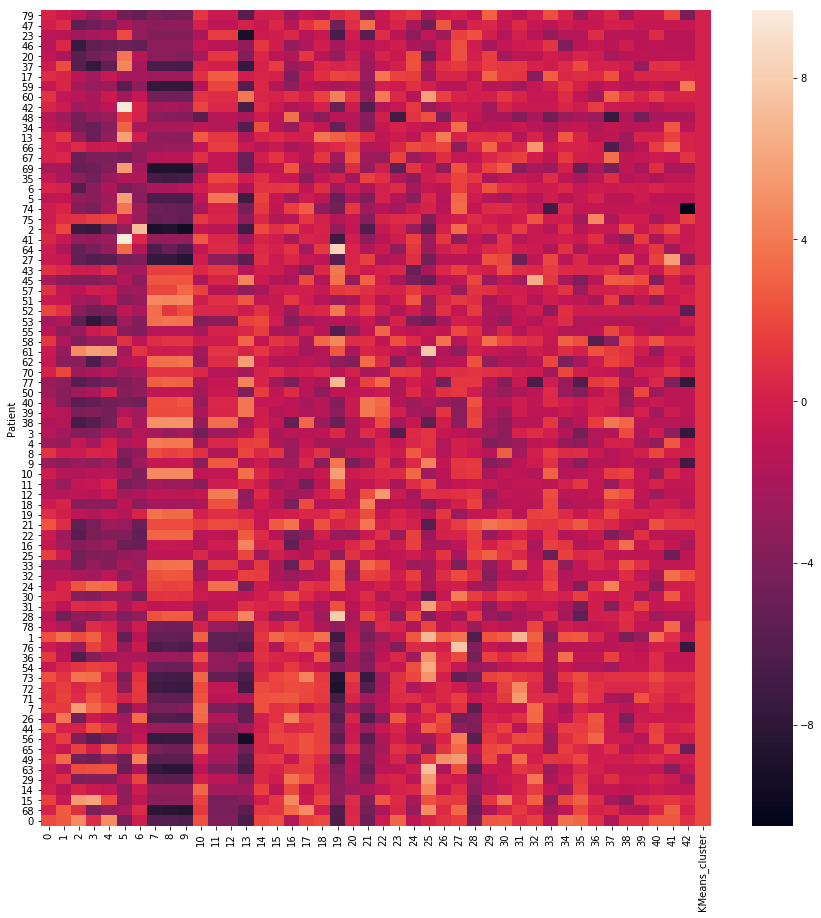

In [28]:

fig, ax = plt.subplots(figsize=(15,15))

## Look at the heatmap of protein expression in all patients and look at their assigned cluster
## Since each protein has a distinct function in the cell, their levels describe the functional/signaling state the cell is in.
processed_p50_plot.index.name = 'Patient'
sb.heatmap(processed_p50_plot) ## The x-axis are the PAM50 proteins we used and the right-most column is the cluster marker
## Looks like the clustering works quite decently here!

In [29]:
processed_p50_plot.head()

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,KMeans_cluster
Patient,,,,,,,,,,,,,,,,,,,,,
79,0.229658,-0.441373,-1.183981,-2.951031,-1.649230,-4.682292,-5.152014,-4.158888,-4.673345,-4.364671,...,0.140188,-2.655777,-0.539791,0.511492,-2.266579,-0.539791,-0.539791,1.858028,-4.315462,0
47,-0.040732,0.620403,-5.539917,-4.749917,-4.077577,-2.057754,-2.971016,-3.422045,-3.214740,-3.214740,...,-0.326477,-0.665448,-0.668250,-0.007115,-0.079952,-0.668250,-0.743888,-0.668250,-0.668250,0
23,-1.183705,-1.312072,-2.614465,-2.199946,-1.718569,2.103030,-3.074447,-3.860696,-3.823256,-3.828604,...,-1.485903,-1.598224,0.747151,-1.312072,-1.312072,-1.312072,0.661573,-1.312072,-1.312072,0
46,-1.349875,0.455181,-7.449721,-5.494549,-5.139396,-4.773258,-5.293173,-3.345323,-3.414889,-3.488117,...,-4.008032,-1.236373,-0.657876,-1.221727,-0.295400,-1.238204,-1.086257,-1.238204,-1.238204,0
20,-0.969020,-1.991062,-5.856105,-4.693713,-3.981163,3.853287,-1.386474,-3.441353,-3.534920,-3.808424,...,-0.580357,0.222162,-0.108922,-2.174597,-1.300104,-1.094976,-1.094976,-1.094976,-1.094976,0


In [30]:
processed_p50_plot["KMeans_cluster"].value_counts()

1    35
0    25
2    20
Name: KMeans_cluster, dtype: int64

**As we see for three clusters the distribution is 34, 20 and 26 pateints in each of the cluster**

In [31]:
processed_p50_plot.describe()

,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,KMeans_cluster
count,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,...,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000,80.000000
mean,-0.243702,-0.627073,-2.370930,-2.242461,-1.644565,-1.659582,-1.756279,-2.160292,-2.190766,-2.203305,...,-0.287025,-0.642217,-0.271185,-0.352583,-0.540505,-0.588849,-0.365382,-0.081732,-1.085615,0.937500
std,1.262916,1.830215,3.033024,3.031010,2.468617,3.237311,2.180784,3.826959,3.808685,3.928751,...,1.650330,2.022195,1.385127,2.002935,1.651909,1.111990,1.537463,1.730413,2.302373,0.752107
min,-2.885329,-4.620440,-7.449721,-7.948412,-6.304754,-5.887760,-5.435575,-9.114133,-8.882091,-9.573385,...,-4.104572,-6.268957,-5.807079,-7.440404,-4.250665,-4.540945,-3.762200,-4.922114,-10.501234,0.000000
25%,-1.038903,-1.764222,-4.518959,-4.261839,-3.688524,-3.835830,-3.128888,-5.287695,-5.089047,-5.310221,...,-1.473688,-1.599387,-1.036148,-1.317966,-1.385734,-1.237791,-1.244828,-1.022162,-1.253231,0.000000
50%,-0.350632,-0.712075,-2.939831,-2.981948,-2.176503,-2.475620,-2.150117,-2.602052,-2.804056,-2.708284,...,-0.185623,-0.729711,-0.372567,-0.464799,-0.686808,-0.700735,-0.411642,-0.393175,-0.691192,1.000000
75%,0.514227,0.459827,-0.691454,-0.395429,0.120775,-1.166901,-0.445541,1.610271,1.258129,1.643313,...,0.754026,0.594431,0.430158,0.847894,0.488025,-0.009732,0.671925,0.734932,0.084220,1.250000
max,2.430691,3.858672,5.625404,6.038440,5.519612,9.668177,7.158672,5.072630,5.137961,5.114903,...,3.585640,3.177722,4.641193,4.267186,3.463713,2.395405,3.487128,5.654961,4.014966,2.000000


## Using Pipelines

In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer

num_pipeline = Pipeline([
        ('imputer', Imputer(missing_values='NaN', strategy='median', axis=1)),
        ('std_scaler', StandardScaler()),
    ])

processed_numerical_p50_pipeline = num_pipeline.fit_transform(processed_numerical_p50_original)

Silhouette Coefficient for k == 2: 0.157
Homogeneity score for k == 2: 0.1565
------------------------
Silhouette Coefficient for k == 3: 0.1318
Homogeneity score for k == 3: 0.4444
------------------------
Silhouette Coefficient for k == 4: 0.1284
Homogeneity score for k == 4: 0.4723
------------------------
Silhouette Coefficient for k == 5: 0.1067
Homogeneity score for k == 5: 0.506
------------------------
Silhouette Coefficient for k == 6: 0.0998
Homogeneity score for k == 6: 0.4939
------------------------
Silhouette Coefficient for k == 7: 0.0942
Homogeneity score for k == 7: 0.555
------------------------
Silhouette Coefficient for k == 8: 0.0752
Homogeneity score for k == 8: 0.5682
------------------------
Silhouette Coefficient for k == 10: 0.0674
Homogeneity score for k == 10: 0.5072
------------------------
Silhouette Coefficient for k == 20: 0.0592
Homogeneity score for k == 20: 0.6389
------------------------


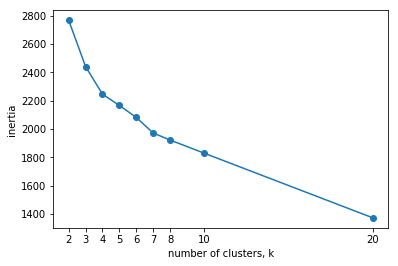

In [33]:
compare_k_means(n_clusters,processed_numerical_p50_pipeline)

**We see similar results as without pipeline. The elbow plot suggests us that optimal value of clusters is 3 or 4, after which there is relatively less drop in inertia.**

In [34]:
clusterer_final = KMeans(n_clusters=3, n_jobs=4)
clusterer_final = clusterer_final.fit(processed_numerical_p50_pipeline)

score_sil = round(metrics.silhouette_score(processed_numerical_p50_pipeline, clusterer_final.labels_), 4)
print(score_sil)

score_homegenity = round(metrics.homogeneity_score(processed['PAM50 mRNA'], clusterer_final.labels_),4)
print(score_homegenity)

0.1314
0.4346


In [35]:
results.loc[len(results)] = ["K Means Pipeline Standard Scaler", 
                             3, 
                             "10",
                             "300",
                             score_sil,
                             score_homegenity,
                             ""]

results

,Algorithm,n_clusters,n_init,max_iter,Silhouette Coefficient,Homogeneity score,Train Time(s)
0,K Means Default,3,10,300,0.1705,0.4021,
1,K Means Default Random protein,3,10,300,0.1066,0.0391,
2,K Means Default with time,3,10,300,0.1753,0.4125,1.819 s
3,K Means Pipeline Standard Scaler,3,10,300,0.1314,0.4346,


In [36]:
from sklearn.preprocessing import Normalizer

In [37]:
num_pipeline = Pipeline([
        ('imputer', Imputer(missing_values='NaN', strategy='median', axis=1)),
        ('std_normalizer', Normalizer()),
    ])

processed_numerical_p50_pipeline = num_pipeline.fit_transform(processed_numerical_p50_original)

Silhouette Coefficient for k == 2: 0.2138
Homogeneity score for k == 2: 0.1804
------------------------
Silhouette Coefficient for k == 3: 0.1516
Homogeneity score for k == 3: 0.3882
------------------------
Silhouette Coefficient for k == 4: 0.1549
Homogeneity score for k == 4: 0.5063
------------------------
Silhouette Coefficient for k == 5: 0.1563
Homogeneity score for k == 5: 0.5288
------------------------
Silhouette Coefficient for k == 6: 0.1052
Homogeneity score for k == 6: 0.5151
------------------------
Silhouette Coefficient for k == 7: 0.1529
Homogeneity score for k == 7: 0.5183
------------------------
Silhouette Coefficient for k == 8: 0.107
Homogeneity score for k == 8: 0.5594
------------------------
Silhouette Coefficient for k == 10: 0.0883
Homogeneity score for k == 10: 0.4789
------------------------
Silhouette Coefficient for k == 20: 0.0819
Homogeneity score for k == 20: 0.6836
------------------------


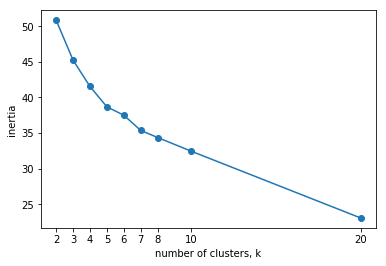

In [38]:
compare_k_means(n_clusters,processed_numerical_p50_pipeline)

In [39]:
clusterer_final = KMeans(n_clusters=3, n_jobs=4)
clusterer_final = clusterer_final.fit(processed_numerical_p50_pipeline)

score_sil = round(metrics.silhouette_score(processed_numerical_p50_pipeline, clusterer_final.labels_), 4)
print(score_sil)

score_homegenity = round(metrics.homogeneity_score(processed['PAM50 mRNA'], clusterer_final.labels_),4)
print(score_homegenity)

0.1554
0.3386


In [40]:
results.loc[len(results)] = ["K Means Pipeline Normalizer", 
                             3, 
                             "10",
                             "300",
                             score_sil,
                             score_homegenity,
                             ""]

results

,Algorithm,n_clusters,n_init,max_iter,Silhouette Coefficient,Homogeneity score,Train Time(s)
0,K Means Default,3,10,300,0.1705,0.4021,
1,K Means Default Random protein,3,10,300,0.1066,0.0391,
2,K Means Default with time,3,10,300,0.1753,0.4125,1.819 s
3,K Means Pipeline Standard Scaler,3,10,300,0.1314,0.4346,
4,K Means Pipeline Normalizer,3,10,300,0.1554,0.3386,


**Using Scaler and Normalizer we see a significant drop in Silhouette Coefficient, although Homogeneity score has improved marginally**

Using full pipeline to normalize and fit

In [41]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", num_pipeline),
        ("linear", KMeans(n_clusters=3, n_jobs=4))
    ])

full_pipeline_with_predictor.fit(processed_numerical_p50_original)

labels = full_pipeline_with_predictor.predict(processed_numerical_p50_original)

print(full_pipeline_with_predictor)

print(labels)

#print(len(labels))

Pipeline(memory=None,
     steps=[('preparation', Pipeline(memory=None,
     steps=[('imputer', Imputer(axis=1, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('std_normalizer', Normalizer(copy=True, norm='l2'))])), ('linear', KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=4, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0))])
[2 2 1 1 0 1 1 2 0 0 0 1 0 1 2 2 0 1 1 0 1 0 0 1 0 1 2 1 0 2 0 0 0 0 1 1 2
 1 0 0 0 1 1 0 2 0 1 1 1 2 1 0 0 0 2 1 2 0 0 1 1 2 0 2 1 2 1 1 2 1 1 2 2 2
 1 2 2 0 2 1]


## AffinityPropagation

In [42]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

In [43]:
# Compute Affinity Propagation
af = AffinityPropagation(preference=-1500).fit(processed_numerical_p50_copy)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

#Considering output of Kmeans as true labels
labels_true = clusterer_final.labels_

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(processed_numerical_p50_copy, labels, metric='sqeuclidean'))


Estimated number of clusters: 3
Homogeneity: 0.445
Completeness: 0.459
V-measure: 0.452
Adjusted Rand Index: 0.330
Adjusted Mutual Information: 0.431
Silhouette Coefficient: 0.174


Affinity propogation algorithm has also generated 3 clusters, conforming to output from kmeans

In [44]:
results.loc[len(results)] = ["Affinity Propogation", 
                             n_clusters_, 
                             "",
                             "200",
                             "%0.3f" % metrics.silhouette_score(processed_numerical_p50_copy, labels, metric='sqeuclidean'),
                             "%0.3f" % metrics.homogeneity_score(labels_true, labels),
                             ""]

results

,Algorithm,n_clusters,n_init,max_iter,Silhouette Coefficient,Homogeneity score,Train Time(s)
0,K Means Default,3,10,300,0.1705,0.4021,
1,K Means Default Random protein,3,10,300,0.1066,0.0391,
2,K Means Default with time,3,10,300,0.1753,0.4125,1.819 s
3,K Means Pipeline Standard Scaler,3,10,300,0.1314,0.4346,
4,K Means Pipeline Normalizer,3,10,300,0.1554,0.3386,
5,Affinity Propogation,3,,200,0.174,0.445,


**Using AffinityPropogation does not provide any increase in Silhouette Coefficient and Homogeneity score over KMeans**

## DBSCAN

In [45]:
from sklearn.cluster import DBSCAN
import numpy as np
from sklearn.preprocessing import StandardScaler

In [46]:
scaled = StandardScaler().fit_transform(processed_numerical_p50_copy)

db = DBSCAN(eps=10).fit(scaled)
#db = DBSCAN(eps=10000, min_samples=5).fit(scaled)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

#Considering output of Kmeans as true labels
labels_true = clusterer_final.labels_

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
#print("Silhouette Coefficient: %0.3f"
 #     % metrics.silhouette_score(scaled, labels))

Estimated number of clusters: 1
Homogeneity: 0.000
Completeness: 1.000
V-measure: 0.000
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.000


It seems DBSCAN is not able to generate any clusters

In [47]:
results.loc[len(results)] = ["DBSCAN", 
                             n_clusters_, 
                             "",
                             "eps = 10",
                             "NA",
                             "%0.3f" % metrics.homogeneity_score(labels_true, labels),
                             ""]

results

,Algorithm,n_clusters,n_init,max_iter,Silhouette Coefficient,Homogeneity score,Train Time(s)
0,K Means Default,3,10,300,0.1705,0.4021,
1,K Means Default Random protein,3,10,300,0.1066,0.0391,
2,K Means Default with time,3,10,300,0.1753,0.4125,1.819 s
3,K Means Pipeline Standard Scaler,3,10,300,0.1314,0.4346,
4,K Means Pipeline Normalizer,3,10,300,0.1554,0.3386,
5,Affinity Propogation,3,,200,0.174,0.445,
6,DBSCAN,1,,eps = 10,NA,0.000,


**DBSCAN algorithm completely failed to form any clusters. So not suitable for out current scenario**

## Mini batch

In [48]:
from sklearn.cluster import MiniBatchKMeans

In [49]:
#As number of observations/features are large, trying mini batch kmeans

mbk = MiniBatchKMeans(init='k-means++', n_clusters=3, batch_size=10,
                      n_init=10, max_no_improvement=10, verbose=0)

t0 = time.time()
#k_means.fit(X)
mbk.fit(processed_numerical_p50_copy)
t_batch = time.time() - t0

#Considering output of Kmeans as true labels
labels = mbk.labels_
labels_true = clusterer_final.labels_

#print('Estimated number of clusters: %d' % n_clusters_)
print("Time taken to fit : %0.3f s" % (t_batch))
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(scaled, labels))

Time taken to fit : 0.019 s
Homogeneity: 0.613
Completeness: 0.634
V-measure: 0.624
Adjusted Rand Index: 0.599
Adjusted Mutual Information: 0.604
Silhouette Coefficient: 0.107


We clearly see that fit time has decreased considerably from 1.4 sec to 0.015 sec
This is huge improvement in terms of speed

In [50]:
results.loc[len(results)] = ["Mini Batch KMeans - Kmeans++", 
                             3, 
                             "10",
                             "300",
                             "%0.3f" % metrics.silhouette_score(scaled, labels),
                             "%0.3f" % metrics.homogeneity_score(labels_true, labels),
                             "%0.3f s" % (t_batch)]

results

,Algorithm,n_clusters,n_init,max_iter,Silhouette Coefficient,Homogeneity score,Train Time(s)
0,K Means Default,3,10,300,0.1705,0.4021,
1,K Means Default Random protein,3,10,300,0.1066,0.0391,
2,K Means Default with time,3,10,300,0.1753,0.4125,1.819 s
3,K Means Pipeline Standard Scaler,3,10,300,0.1314,0.4346,
4,K Means Pipeline Normalizer,3,10,300,0.1554,0.3386,
5,Affinity Propogation,3,,200,0.174,0.445,
6,DBSCAN,1,,eps = 10,NA,0.000,
7,Mini Batch KMeans - Kmeans++,3,10,300,0.107,0.613,0.019 s


**We see significant improvement in train time when using mini batch K means. Improved value is 0.020s as against 1.317s for default KMeans. But this is at the cost of significant drop in Silhouette Coefficient**

In [51]:
!pip install Biopython

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


## Discussion for Unsupervised learning using KMeans

*1. From the combined table as seen above, we see best clusters that we can form as 3 and 4. 
We chose 3 and compared the same for other algorithms. 
As it turns out full batch KMeans is giving best score in terms of Silhouette Coefficient and Homogeneity score.*

*2. The elbow plot for default KMeans suggests us that optimal value of clusters is 3 or 4, after which there is relatively less drop in inertia. We choose 3 as number of desired clusters*

*3. for three clusters the distribution is 34, 20 and 26 pateints in each of the cluster*

*4. Total time taken by default K means for extrcating 3 clusters is 1.317s*

*5. Using Scaler and Normalizer we see a significant drop in Silhouette Coefficient, although Homogeneity score has improved marginally*

*6. Using AffinityPropogation does not provide any increase in Silhouette Coefficient and Homogeneity score over KMeans*

*7. DBSCAN algorithm completely failed to form any clusters. So not suitable for out current scenario*

*8. We see significant improvement in train time when using mini batch K means. Improved value is 0.020s as against 1.317s for default KMeans. But this is at the cost of significant drop in Silhouette Coefficient*

## Preprocessing for principal component analysis

In [52]:
import os
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
import matplotlib.pyplot as plt
from numpy import linalg as LA
from Bio.Cluster import pca  # For PCA analysis

from sklearn.decomposition import PCA
import os
%matplotlib inline

Parsing out the patient ID and their corresponding histological type (ER+, HER2+, TNBC, Uncharacterized)

In [53]:
filename1="TCGApattype.txt"

patientId=[]
pattype=[]
for line in open(filename1,'r'):
   line2=line.split("\t")
   pat=line2[0].split("-") 
   try: 
      patientId.append(pat[1]+"-"+pat[2])
      pattype.append(line2[1].replace("\n",""))  
   except IndexError:
      pass
patientId=np.array(patientId)
print ("Unique labels:",list(set(pattype)))

Unique labels: ['Undetermined', 'TNBC', 'ER/PR-Positive', 'HER2-Positive']


Now reading the gene expression file and parsing out the histological type for each of the patients

In [54]:
import pandas as pd
filename2="77_cancer_proteomes_CPTAC_itraq.csv"
df=pd.read_csv(filename2,header=[0])
# Cleaning the data frame and getting rid of rows having missing data
df_cleaned=df.transpose().dropna(axis=1, how='any').drop(["RefSeq_accession_number","gene_symbol","gene_name","263d3f-I.CPTAC","blcdb9-I.CPTAC","c4155b-C.CPTAC"])

hist_cat=[]
for patid in df_cleaned.index:
      pat=patid.split(".") 
      ind = np.where(patientId==pat[0])
      if len(ind[0])>0:  
         for k in ind[0]:
            hist_cat.append(pattype[k])
            #print (pat[0],pattype[k])
            break
      else:
         print ("Annotation not available:",pat[0])
            
            
# Counting number of TNBC, ER/PR+, Unidentified and HER2+
count_hist=Counter(hist_cat)
num_undetermined=count_hist["Undetermined"]
num_ER=count_hist["ER/PR-Positive"]
num_HER=count_hist["HER2-Positive"]
num_TNBC=count_hist["TNBC"]            
            
df_cleaned.head()            

,0,2,5,6,9,10,11,12,14,15,...,12197,12214,12260,12265,12316,12323,12385,12432,12463,12464
AO-A12D.01TCGA,1.09613,1.11137,1.10756,1.11137,0.482754,0.261785,0.92469,-0.58018,-0.187771,2.04477,...,-1.52882,-0.740192,0.235117,-1.57835,6.78035,-1.01069,-0.119194,-2.02409,1.63712,-0.252537
C8-A131.01TCGA,2.60994,2.65042,2.64637,2.65042,-1.04529,-0.0373711,1.39963,-0.13452,0.173119,1.59392,...,-0.952192,0.812684,-0.442159,1.03937,1.17699,-0.0495148,1.14461,-0.166903,1.0596,2.19301
AO-A12B.01TCGA,-0.659828,-0.654285,-0.654285,-0.648742,1.222,1.01969,-1.23075,0.781338,-1.78505,-1.26678,...,1.49084,-1.69913,1.9509,-2.586,2.14767,-2.57769,-1.20304,-3.07101,1.64881,-2.81326
BH-A18Q.02TCGA,0.195341,0.215413,0.215413,0.215413,-0.517226,-0.724639,-0.0856714,-0.306467,2.04199,1.02834,...,-0.721294,-1.658,0.707184,2.14904,3.8117,-0.329884,1.70076,2.35311,0.422827,0.389373
C8-A130.02TCGA,-0.49406,-0.500619,-0.503899,-0.500619,-0.405503,-0.703971,-0.785968,-0.917163,-0.520299,0.109436,...,-0.576056,-1.67481,1.66409,1.20163,-1.18283,2.48078,0.371826,-1.44522,0.493181,2.36927


## Carrying out principal component analysis using biopython PCA package

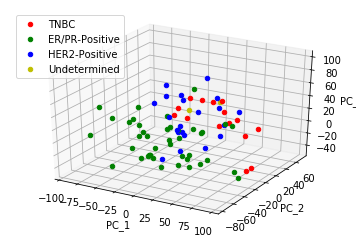

In [55]:
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
columnmean, coordinates, components, eigenvalues = pca(df_cleaned.values) # PCA analysis
#print "columnmean:",columnmean
#print "coordinates:",coordinates
#print "components:",components
#print "eigenvalues:",eigenvalues

eigenlist = eigenvalues
length = len(eigenlist)
coord = np.zeros(3)
b=0
for i in range(3):   # Calculating the 3 greatest eigenvalues to be chosen as the axes for the PCA graph
    a = 0
    for j in range(length):   
              if eigenlist[j] >= a:
                 a = eigenlist[j]
              
    for k in range(length):
              if eigenlist[k] == a:   
                 coord[b] = k
                 eigenlist[k] = 0
                 b+=1                
                
# Plotting results of PCA analysis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#print coordinates
for i in range(length):
    xs = coordinates[i,int(coord[0])]
    ys = coordinates[i,int(coord[1])]
    zs = coordinates[i,int(coord[2])]
    #print (i, pattype[i])
    if hist_cat[i]=="TNBC":
           TNBC=ax.scatter(xs, ys, zs, c='r', marker='o')
    elif hist_cat[i]=="ER/PR-Positive":
           ER=ax.scatter(xs, ys, zs, c='g', marker='o')
    elif hist_cat[i]=="HER2-Positive":
           PR=ax.scatter(xs, ys, zs, c='b', marker='o')
    elif hist_cat[i]=="Undetermined":
           HER=ax.scatter(xs, ys, zs, c='y', marker='o')
ax.set_xlabel('PC_1')
ax.set_ylabel('PC_2')
ax.set_zlabel('PC_3')
fig.set_facecolor('white')
plt.legend([TNBC, ER, PR, HER],["TNBC","ER/PR-Positive","HER2-Positive","Undetermined"],loc=2)
plt.show()

## Computing clusters in principal component analysis

The PCA algorithm in [scikit](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) does not have a predict function, therefore the predicted values need to be calculated manually. For computing the boundary of each of the clusters corresponding to each of the histological type, the median of the corrdinates of all the patients belonging to a particular histological type are taken as the center and the standard deviation as the radius.

In [56]:
def calculate_clusters(tnbc, er, her):
    
   # Calculating center and radius of each histological type

   tnbc_center=[np.median(tnbc[:,0]), np.median(tnbc[:,1]), np.median(tnbc[:,2])] 
   tnbc_radius=LA.norm([np.std(tnbc[:,0]), np.std(tnbc[:,1]), np.std(tnbc[:,2])],2)
   er_center=[np.median(er[:,0]), np.median(er[:,1]), np.median(er[:,2])] 
   er_radius=LA.norm([np.std(er[:,0]), np.std(er[:,1]), np.std(er[:,2])],2)
   her_center=[np.median(her[:,0]), np.median(her[:,1]), np.median(her[:,2])] 
   her_radius=LA.norm([np.std(her[:,0]), np.std(her[:,1]), np.std(her[:,2])],2)
    
   # Calculating purity of each histological type 
   X=np.concatenate([tnbc, er, her], axis=0)
   num_tnbc=tnbc.shape[0]
   num_er=er.shape[0]
   num_her=her.shape[0]
   tnbc_tp=0
   tnbc_fp=0
   er_tp=0
   er_fp=0
   her_tp=0
   her_fp=0 
   for i in range(X.shape[0]):
      if i<num_tnbc:
        hist_type="TNBC"
      elif i>=num_tnbc and i<(num_tnbc+num_er):
        hist_type="ER/PR-Positive" 
      elif i>=(num_tnbc+num_er) and i<(num_tnbc+num_er+num_her):
        hist_type="HER2-Positive"
        
      if (LA.norm(tnbc_center - X[i,:],2) < tnbc_radius) and hist_type=="TNBC":
         tnbc_tp+=1
      elif (LA.norm(tnbc_center - X[i,:],2) < tnbc_radius) and hist_type!="TNBC":
         tnbc_fp+=1
            
      if (LA.norm(er_center - X[i,:],2) < er_radius) and hist_type=="ER/PR-Positive":
         er_tp+=1
      elif (LA.norm(er_center - X[i,:],2) < er_radius) and hist_type!="ER/PR-Positive":
         er_fp+=1
            
            
      if (LA.norm(her_center - X[i,:],2) < her_radius) and hist_type=="HER2-Positive":
         her_tp+=1
      elif (LA.norm(her_center - X[i,:],2) < her_radius) and hist_type!="HER2-Positive":
         her_fp+=1
            
   tnbc_purity=tnbc_tp/(tnbc_tp+tnbc_fp)
   er_purity=er_tp/(er_tp+er_fp)
   her_purity=her_tp/(her_tp+her_fp)
   #print (tnbc_purity, er_purity, her_purity)
   return (tnbc_purity, er_purity, her_purity)

## Using scikit learn package for principal component analysis

Estimating the number of clusters using PCA and logistic regression

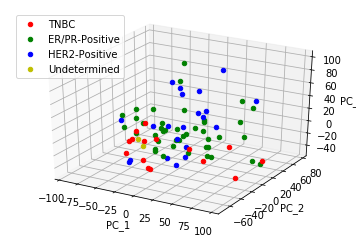

Purity of TNBC cluster: 0.39285714285714285 
 Purity of ER/PR-Positive cluster 0.8285714285714286 
 Purity of HER2-Positive 0.52 



In [57]:
sklearn_pca = PCA(n_components=3)
coordinates = sklearn_pca.fit_transform(df_cleaned.values)
# Plotting results of PCA analysis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#print coordinates
tnbc=np.zeros((num_TNBC,3)) # Storing TNBC patient coordinates
er=np.zeros((num_ER,3)) # Storing ER/PR-Positive patient coordinates
her=np.zeros((num_HER,3)) # Storing HER2-Positive patient coordinates
un=np.zeros((num_undetermined,3)) # Storing undetermined patient coordinates
m=0
n=0
o=0
p=0
for i in range(coordinates.shape[0]):
    xs = coordinates[i,0]
    ys = coordinates[i,1]
    zs = coordinates[i,2]
    if hist_cat[i]=="TNBC":
           TNBC=ax.scatter(xs, ys, zs, c='r', marker='o')
           tnbc[m,0]=xs
           tnbc[m,1]=ys
           tnbc[m,2]=zs
           m+=1 
    elif hist_cat[i]=="ER/PR-Positive":
           ER=ax.scatter(xs, ys, zs, c='g', marker='o')
           er[n,0]=xs
           er[n,1]=ys
           er[n,2]=zs
           n+=1
    elif hist_cat[i]=="HER2-Positive":
           HER=ax.scatter(xs, ys, zs, c='b', marker='o')
           her[o,0]=xs
           her[o,1]=ys
           her[o,2]=zs
           o+=1
    elif hist_cat[i]=="Undetermined":
           UN=ax.scatter(xs, ys, zs, c='y', marker='o')
           un[p,0]=xs
           un[p,1]=ys
           un[p,2]=zs
           p+=1            
ax.set_xlabel('PC_1')
ax.set_ylabel('PC_2')
ax.set_zlabel('PC_3')
fig.set_facecolor('white')
plt.legend([TNBC, ER, HER, UN],["TNBC","ER/PR-Positive","HER2-Positive","Undetermined"],loc=2)
plt.show()

# Calculating clusters and the their respective purity
tnbc_purity, er_purity, her_purity=calculate_clusters(tnbc, er, her)
print ("Purity of TNBC cluster:",tnbc_purity,"\n", "Purity of ER/PR-Positive cluster", er_purity, "\n", "Purity of HER2-Positive", her_purity, "\n")

## Discussion of PCA results

From analyzing the purity values from the PCA analysis, we find them to be quite low. But when we visualize the clusters we do find a significant amount of clustering of patients having similar histological type. The reason for this discrepancy is that we are making an assumption that the clusters are spherical, but from the graph above we observe that this is not the case. 

Generally, for unsupervised learning we estimate the accuracy of the clustering using the adjusted Rand index. However, in the case of PCA, all the patients do not have a predicted label. This is because some patients are not within the radius of any of the cluster spheres.

Next week, [agglomerative clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering) shall be used which has a predict function which would allow calculating the adjusted rand index for the entire dataset.

# Phase 2 - Feature engineering + Hyperparameter tuning 

## Using GRID Search to find optimal values for hyper pamameters

In [58]:
# GRID Search and Random Search

In [59]:
from sklearn.model_selection import KFold, GridSearchCV

RAND_STATE=50  # for reproducibility and consistency
folds=3
k_fold = KFold(n_splits=folds, shuffle=True, random_state=RAND_STATE)  # setting generator for k-fold splitting

hyperparams = {
    "n_clusters": [2, 3],
    "n_init": [10, 15, 20],
    "max_iter": [100, 200, 300, 400, 500],
    "tol": [.0000001, .000001, .00001, .0001],
}

k_means = KMeans()  # sets jobs equal to number of cores

grid_search = GridSearchCV(
    estimator=k_means,
    param_grid=hyperparams,
    cv=k_fold,
    n_jobs=-1
)

grid_search.fit(processed_numerical_p50)

GridSearchCV(cv=KFold(n_splits=3, random_state=50, shuffle=True),
       error_score='raise',
       estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_clusters': [2, 3], 'n_init': [10, 15, 20], 'max_iter': [100, 200, 300, 400, 500], 'tol': [1e-07, 1e-06, 1e-05, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [60]:
grid_search.best_params_

{'max_iter': 400, 'n_clusters': 3, 'n_init': 20, 'tol': 1e-05}

In [61]:
grid_search.best_estimator_

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=400,
    n_clusters=3, n_init=20, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=1e-05, verbose=0)

In [62]:
grid_search.best_score_

-4478.0581360243887

In [63]:
from sklearn.metrics import silhouette_score, homogeneity_score

In [64]:
# Generate labels for data with model with raw data, compute score

#Considering output of Kmeans as true labels
labels_true = clusterer_final.labels_

labels = grid_search.predict(processed_numerical_p50)
score = silhouette_score(processed_numerical_p50, labels)
score2 = homogeneity_score(labels_true, labels)
print(score)
print(score2)
print(grid_search.best_params_)

0.175329407083
0.701246355588
{'max_iter': 400, 'n_clusters': 3, 'n_init': 20, 'tol': 1e-05}


We again calculate silhoutte score, which shows how close the points are to the center of their clusters (tighter clusters will give us a better score, if the data points are very scattered, this indicates that our clusters are too loose). The values for the score range from [-1, 1] and a score of 1 is ideal.

In [65]:
results.loc[len(results)] = ["GRIDSearch CV", 
                             grid_search.best_params_["n_clusters"], 
                             grid_search.best_params_["n_init"], 
                             grid_search.best_params_["max_iter"], 
                             score,
                             score2,
                             ""]

results

,Algorithm,n_clusters,n_init,max_iter,Silhouette Coefficient,Homogeneity score,Train Time(s)
0,K Means Default,3,10,300,0.1705,0.4021,
1,K Means Default Random protein,3,10,300,0.1066,0.0391,
2,K Means Default with time,3,10,300,0.1753,0.4125,1.819 s
3,K Means Pipeline Standard Scaler,3,10,300,0.1314,0.4346,
4,K Means Pipeline Normalizer,3,10,300,0.1554,0.3386,
5,Affinity Propogation,3,,200,0.174,0.445,
6,DBSCAN,1,,eps = 10,NA,0.000,
7,Mini Batch KMeans - Kmeans++,3,10,300,0.107,0.613,0.019 s
8,GRIDSearch CV,3,20,400,0.175329,0.701246,


**With GRID search we see slightly improved Silhouette score as we saw before for KMeans.**

**But we see good improvement for homogeneity score.**

**Best parameters are printed above**

## Using Random Search and/or RandomSearch to use and find optimal values for hyper pamameters

In [66]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform
from scipy.stats import randint

In [67]:
RAND_STATE=50  # for reproducibility and consistency
folds=3
k_fold = KFold(n_splits=folds, shuffle=True, random_state=RAND_STATE)  # setting generator for k-fold splitting

hyperparams = {
    "n_clusters": randint(low=2, high=6),
    "n_init": randint(low=10, high=20),
    "max_iter": randint(low=100, high=500),
    #"tol": [.0000001, .000001, .00001, .0001],
}

k_means = KMeans()  # sets jobs equal to number of cores

random_search = RandomizedSearchCV(
    estimator=k_means,
    param_distributions=hyperparams,
    cv=k_fold,
    n_jobs=-1
)

random_search.fit(processed_numerical_p50)

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=50, shuffle=True),
          error_score='raise',
          estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'n_clusters': <scipy.stats._distn_infrastructure.rv_frozen object at 0x00000211369370B8>, 'n_init': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002113AA2E898>, 'max_iter': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002113A881C50>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [68]:
random_search.best_params_

{'max_iter': 106, 'n_clusters': 5, 'n_init': 16}

In [69]:
random_search.best_estimator_

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=106,
    n_clusters=5, n_init=16, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [70]:
random_search.best_score_

-4356.6818557922916

In [71]:
#Considering output of Kmeans as true labels
labels_true = clusterer_final.labels_

labels = random_search.predict(processed_numerical_p50)
score = silhouette_score(processed_numerical_p50, labels)
score2 = homogeneity_score(labels_true, labels)
print(score)
print(score2)
print(random_search.best_params_)

0.136652610919
0.736796621569
{'max_iter': 106, 'n_clusters': 5, 'n_init': 16}


In [72]:
results.loc[len(results)] = ["RandomSearch CV", 
                             random_search.best_params_["n_clusters"], 
                             random_search.best_params_["n_init"], 
                             random_search.best_params_["max_iter"], 
                             score,
                             score2,
                             ""]

results

,Algorithm,n_clusters,n_init,max_iter,Silhouette Coefficient,Homogeneity score,Train Time(s)
0,K Means Default,3,10,300,0.1705,0.4021,
1,K Means Default Random protein,3,10,300,0.1066,0.0391,
2,K Means Default with time,3,10,300,0.1753,0.4125,1.819 s
3,K Means Pipeline Standard Scaler,3,10,300,0.1314,0.4346,
4,K Means Pipeline Normalizer,3,10,300,0.1554,0.3386,
5,Affinity Propogation,3,,200,0.174,0.445,
6,DBSCAN,1,,eps = 10,NA,0.000,
7,Mini Batch KMeans - Kmeans++,3,10,300,0.107,0.613,0.019 s
8,GRIDSearch CV,3,20,400,0.175329,0.701246,
9,RandomSearch CV,5,16,106,0.136653,0.736797,


As we see in this case random search did not give higher score than GRID search

**For random search we do not see better score than GRID search. Though Homogenity score for Random search is still higher than defaul KMeans**

**Best parameters for Random search are printed above**


## Using GRID Search to find metrics when increasing the search for cluster size

In [73]:
RAND_STATE=50  # for reproducibility and consistency
folds=3
k_fold = KFold(n_splits=folds, shuffle=True, random_state=RAND_STATE)  # setting generator for k-fold splitting

hyperparams = {
    "n_clusters": [2, 3,4,5,6,7,8],
    "n_init": [10, 15, 20],
    "max_iter": [100, 200, 300, 400, 500],
    "tol": [.0000001, .000001, .00001, .0001],
}

k_means = KMeans()  # sets jobs equal to number of cores

grid_search = GridSearchCV(
    estimator=k_means,
    param_grid=hyperparams,
    cv=k_fold,
    n_jobs=-1
)

grid_search.fit(processed_numerical_p50)

GridSearchCV(cv=KFold(n_splits=3, random_state=50, shuffle=True),
       error_score='raise',
       estimator=KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_clusters': [2, 3, 4, 5, 6, 7, 8], 'n_init': [10, 15, 20], 'max_iter': [100, 200, 300, 400, 500], 'tol': [1e-07, 1e-06, 1e-05, 0.0001]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [74]:
grid_search.best_params_


{'max_iter': 400, 'n_clusters': 8, 'n_init': 15, 'tol': 1e-06}

In [75]:

grid_search.best_estimator_


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=400,
    n_clusters=8, n_init=15, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=1e-06, verbose=0)

In [76]:

grid_search.best_score_

-4168.6297293555208

In [77]:
# Generate labels for data with model with raw data, compute score

#Considering output of Kmeans as true labels
labels_true = clusterer_final.labels_

labels = grid_search.predict(processed_numerical_p50)
score = silhouette_score(processed_numerical_p50, labels)
score2 = homogeneity_score(labels_true, labels)
print(score)
print(score2)
print(grid_search.best_params_)

0.124330685353
0.721575359598
{'max_iter': 400, 'n_clusters': 8, 'n_init': 15, 'tol': 1e-06}


In [78]:
results.loc[len(results)] = ["GRID Search CV Increased cluster", 
                             grid_search.best_params_["n_clusters"], 
                             grid_search.best_params_["n_init"], 
                             grid_search.best_params_["max_iter"], 
                             score,
                             score2,
                             ""]

results

,Algorithm,n_clusters,n_init,max_iter,Silhouette Coefficient,Homogeneity score,Train Time(s)
0,K Means Default,3,10,300,0.1705,0.4021,
1,K Means Default Random protein,3,10,300,0.1066,0.0391,
2,K Means Default with time,3,10,300,0.1753,0.4125,1.819 s
3,K Means Pipeline Standard Scaler,3,10,300,0.1314,0.4346,
4,K Means Pipeline Normalizer,3,10,300,0.1554,0.3386,
5,Affinity Propogation,3,,200,0.174,0.445,
6,DBSCAN,1,,eps = 10,NA,0.000,
7,Mini Batch KMeans - Kmeans++,3,10,300,0.107,0.613,0.019 s
8,GRIDSearch CV,3,20,400,0.175329,0.701246,
9,RandomSearch CV,5,16,106,0.136653,0.736797,


**We use GRID Search to find scores for Silhouette Coefficient and Homogeneity score.**

**Increasing the cluster we see that we get higher cluster size 8 as the best model in which homogeneity score increases but the silhoutte score descreases.**

**Seems clutser size 3 is a good fit for us**

## Discussion for GRID/Random Search and Hyper parameter tuning for unsupervsed learning

_1. With GRID search we see slightly improved Silhouette score as we saw before for KMeans._

_But we see good improvement for homogeneity score which has improved from 0.4125 to 0.8803._

Best parameters are {'max_iter': 100, 'n_clusters': 3, 'n_init': 15, 'tol': 1e-06}_



_2. For random search we do not see better score than GRID search. Though Homogenity score for Random search is still higher than defaul KMeans_

Best parameters for Random search are {'max_iter': 435, 'n_clusters': 4, 'n_init': 14}_



_3. We use GRID Search to find scores for Silhouette Coefficient and Homogeneity score._

_Increasing the cluster we see that we get higher cluster size 8 as the best model in which homogeneity score increases but the silhoutte score descreases._

_Seems clutser size 3 is a good fit for us_




## Tuning of number of components using principal component analysis.

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logistic', LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


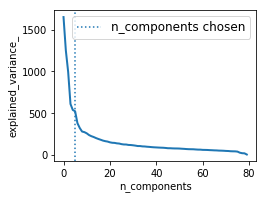

In [79]:
from sklearn import linear_model, decomposition
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

logistic = linear_model.LogisticRegression(C=0.1,penalty='l1')

pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])



# Plot the PCA spectrum
pca.fit(df_cleaned.values)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

# Prediction
n_components = [1, 2, 3, 4, 5]
Cs = [ 1]

# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              logistic__C=Cs))
estimator.fit(df_cleaned.values, hist_cat)
print (estimator.best_estimator_)
plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()

In the plot above, the number of components chosen by the PCA algorithm by estimating variances of different number of clusters is 5 which is very close to the actual number of components 3 (TNBC, ER/PR positive and HER2 positive).

## Selection of genes most suitable for identifying breast cancer subtypes using random forests

Feature engineering using [random forest](http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html#sphx-glr-auto-examples-ensemble-plot-forest-importances-py)

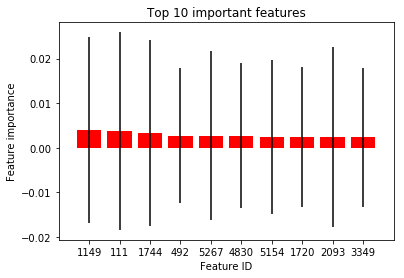

In [80]:
from sklearn.ensemble import ExtraTreesClassifier
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(df_cleaned.values, hist_cat)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
#print("Feature ranking:")

#for f in range(10): # df_cleaned.values.shape[1]
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Top 10 important features")
#plt.bar(range(df_cleaned.values.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
#plt.xticks(range(df_cleaned.values.shape[1]), indices)
plt.bar(range(10), importances[indices[:10]], color="r", yerr=std[indices[:10]], align="center")
plt.xticks(range(10), indices[:10])        
plt.xlim([-1, 10])
plt.ylabel('Feature importance')
plt.xlabel('Feature ID')
plt.show()

In the bar plot above, the feature importance for each gene in the random forest has been plotted. The error bars represent the standard deviation of the feature importance of each decision tree in the random forest. The plot suggests that there is no single gene which is repsonsible for any particular breast cancer subtype. Rather the combination of various genes are responsible for the observed histological type. 

## Feature reduction using L1 penalization

In [81]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_selection import SelectFromModel


## Feature selection using L1 penalization
lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(df_cleaned.values, hist_cat)
selection_model = SelectFromModel(lsvc, prefit=True)
X_new = selection_model.transform(df_cleaned.values)

print ("Shape of original dataset:", df_cleaned.values.shape)
print ("Shape of new dataset after L1 penalization:", X_new.shape,"\n\n")

print ("List containing whether a protein was selected or not")
selection_result=selection_model.get_support()
print (selection_result)


Shape of original dataset: (80, 6912)
Shape of new dataset after L1 penalization: (80, 36) 


List containing whether a protein was selected or not
[False False False ..., False False False]


The linear L1 penalization has reduced the number of variables from 6912 to 36. That is a very significant reduction in the number of possible variables

## Estimation of number of components with L1 regularized dataset.

C:\Users\LENOVO\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:605: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('logistic', LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])


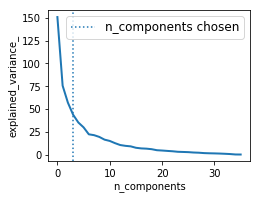

In [82]:
from sklearn import linear_model, decomposition
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

logistic = linear_model.LogisticRegression(C=0.1,penalty='l1')

pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# Plot the PCA spectrum
pca.fit(X_new)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

# Prediction
n_components = [1, 2, 3, 4, 5]
Cs = [ 1]

# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              logistic__C=Cs))
estimator.fit(X_new, hist_cat)
print (estimator.best_estimator_)
plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()

## Principal component analysis with L1 regularized dataset.

Using L1 regularized dataset for estimation of the number of components, its observed that it makes the correct number of clusters = 3. This is a significant improvement over the result obtained from the unregularized dataset. 

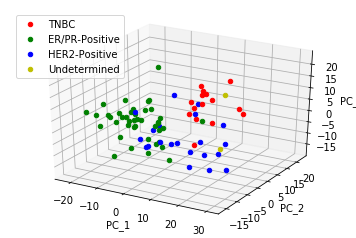

Purity of TNBC cluster: 0.7857142857142857 
 Purity of ER/PR-Positive cluster 0.8620689655172413 
 Purity of HER2-Positive 0.34210526315789475 



In [83]:
sklearn_pca = PCA(n_components=3)
coordinates = sklearn_pca.fit_transform(X_new)
# Plotting results of PCA analysis
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#print coordinates
tnbc=np.zeros((num_TNBC,3)) # Storing TNBC patient coordinates
er=np.zeros((num_ER,3)) # Storing ER/PR-Positive patient coordinates
her=np.zeros((num_HER,3)) # Storing HER2-Positive patient coordinates
un=np.zeros((num_undetermined,3)) # Storing undetermined patient coordinates
m=0
n=0
o=0
p=0
for i in range(coordinates.shape[0]):
    xs = coordinates[i,0]
    ys = coordinates[i,1]
    zs = coordinates[i,2]
    if hist_cat[i]=="TNBC":
           TNBC=ax.scatter(xs, ys, zs, c='r', marker='o')
           tnbc[m,0]=xs
           tnbc[m,1]=ys
           tnbc[m,2]=zs
           m+=1 
    elif hist_cat[i]=="ER/PR-Positive":
           ER=ax.scatter(xs, ys, zs, c='g', marker='o')
           er[n,0]=xs
           er[n,1]=ys
           er[n,2]=zs
           n+=1
    elif hist_cat[i]=="HER2-Positive":
           HER=ax.scatter(xs, ys, zs, c='b', marker='o')
           her[o,0]=xs
           her[o,1]=ys
           her[o,2]=zs
           o+=1
    elif hist_cat[i]=="Undetermined":
           UN=ax.scatter(xs, ys, zs, c='y', marker='o')
           un[p,0]=xs
           un[p,1]=ys
           un[p,2]=zs
           p+=1            
ax.set_xlabel('PC_1')
ax.set_ylabel('PC_2')
ax.set_zlabel('PC_3')
fig.set_facecolor('white')
plt.legend([TNBC, ER, HER, UN],["TNBC","ER/PR-Positive","HER2-Positive","Undetermined"],loc=2)
plt.show()

# Calculating clusters and the their respective purity
tnbc_purity, er_purity, her_purity=calculate_clusters(tnbc, er, her)
print ("Purity of TNBC cluster:",tnbc_purity,"\n", "Purity of ER/PR-Positive cluster", er_purity, "\n", "Purity of HER2-Positive", her_purity, "\n")

When we compare the purity results from the PCA analysis done above to the one with the original dataset, we find that the purity of the TNBC cluster has improved significantly. Even on visual inspection, it is observed that the three categories are clustering out better than in case of the original dataset.

## Discussion - Phase 2

In Phase 2, we did tuning of the hyperparameters mainly the number of components in the PCA cluster. For the original dataset, the number of components obtained using grid search involving PCA and logistic regression was 5.

Various algorithms were considered for feature selection of relevant genes which can help in predicting breast cancer subtype. Random forests were used for determining genes which can help in predicting breast cancer subtype. However the standard deviation between various decision trees was very high and no conclusions could be made.

Feature selection using L1 penalization was attempted and it reduced the number of features from 6912 to 36. The number of PCA components derived from the regularized dataset was 3 which is in complete agreement with the expected number of clusters. Further, we did PCA with the new regularized dataset. There was an increase in the percentage of purity for the TNBC cluster. This suggests that the L1 penalization improved the overall quality of the unsupervised learning with PCA.

# Phase 3 - Success/failure analysis

## Introduction to phase 3

In phase 2 of the project, we reduced the number of features using L1 penalization. We were successfully able to predict the expected number of breast cancer subtypes (i.e number of clusters). Now we want to compare how many genes were succesfully predicted against the PAM50 dataset.

## Determining common features between L1 regularized dataset and PAM50

In [84]:
# Extracting the RefSeq protein ID's of the genes from the original dataset.

df_cleaned_parsed=df.transpose().dropna(axis=1, how='any').drop(["RefSeq_accession_number","gene_name","263d3f-I.CPTAC","blcdb9-I.CPTAC","c4155b-C.CPTAC"])
df_cleaned_features=np.array(df_cleaned_parsed.transpose()["gene_symbol"])

# selection_result is the list containing whether a feature was extracted or not
print (("Number of unique proteins in the cleaned dataset:"),len(np.unique(df_cleaned_features)),"\n")

i=0
selected_features=[]
#print ("Gene names of selected features:")
for status in selection_result:
    if status==True:
        selected_features.append(df_cleaned_features[i])
        #print (df_cleaned_features[i])
    i+=1
selected_features=np.array(selected_features)

#Extracting PAM50 gene names

#print ("PAM50 gene names:")
pam50_features=np.array(list(set(pam50["GeneSymbol"])))

print("Number of proteins common between PAM50 dataset and the cleaned dataset:")
df_cleaned_pam50_features=np.intersect1d(df_cleaned_features, pam50_features)
print (len(df_cleaned_pam50_features))

common_features=np.intersect1d(selected_features, pam50_features)

print ("Number of features successfully detected which were part of the PAM50 dataset")
print (len(common_features))

Number of unique proteins in the cleaned dataset: 6338 

Number of proteins common between PAM50 dataset and the cleaned dataset:
21
Number of features successfully detected which were part of the PAM50 dataset
4


In the code above, we calculated first the number of proteins that were common between the original cleaned dataset and the PAM50 dataset. A total of 21 proteins were common between the two datasets (df_cleaned_pam50_features). Next, we calculated the number of proteins common between the selected dataset and the df_cleaned_pam50_features. We found 4 proteins to be common between the two datasets.

## Calculating significance of the number of correctly determined proteins in PAM50 dataset.

In the previous section, 21 proteins out of the 50 proteins in the PAM50 dataset were found in the original cleaned dataset. Out of these 21 proteins, only 4 proteins were selected in our L1 regularized dataset. We now need to determine whether 4/21 genes we found were due to pure random chance or is this ratio statistically significant. 

For this we shall calculate the binomial p-value using the [binom_test](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.binom_test.html) function in scipy.

The probability of getting a single protein, p =(Number of PAM50 proteins)/(Total number of proteins in original cleaned dataset) = 21/6338

Number of successful hits, x = 4

Total number of proteins in the L1 regularized dataset, n = 36

In [85]:
import scipy
p_value=scipy.stats.binom_test(x=4, n=36, p=21/6338)
print ("Binomal p-value is", p_value)

if p_value < 0.05:
   print ("Number of successful PAM50 hits is statistically significant and we can reject the null hypothesis.")
else:
   print ("Not statistically significant, null hypothesis cannot be rejected.") 

Binomal p-value is 6.52225312566e-06
Number of successful PAM50 hits is statistically significant and we can reject the null hypothesis.


## Gaussian Mixture Models

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.

A GaussianMixture.fit method is provided that learns a Gaussian Mixture Model from train data. Given test data, it can assign to each sample the Gaussian it mostly probably belong to using the GaussianMixture.predict method.

Gaussian Mixture Models provides four options diagonal, spherical, tied and full covariance matrices. We choose all four to study our classification

In [86]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [87]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer

In [88]:
num_pipeline = Pipeline([
        ('imputer', Imputer(missing_values='NaN', strategy='median', axis=1)),
    ])

processed_numerical_p50_pipeline = num_pipeline.fit_transform(processed_numerical_p50_original)

In [89]:
from sklearn import preprocessing

In [90]:
le = preprocessing.LabelEncoder()

le.fit(processed['PAM50 mRNA'])

target = le.transform(processed['PAM50 mRNA'])
target

array([0, 0, 1, 2, 2, 3, 3, 0, 3, 2, 2, 2, 2, 3, 0, 0, 3, 3, 3, 3, 1, 3, 2,
       1, 2, 3, 0, 3, 3, 0, 3, 0, 2, 3, 1, 2, 0, 3, 2, 3, 3, 1, 1, 2, 0, 2,
       3, 3, 1, 0, 2, 2, 3, 2, 0, 2, 2, 3, 3, 2, 2, 2, 2, 0, 3, 1, 1, 3, 0,
       1, 1, 0, 0, 0, 1, 1, 0, 2, 0, 3], dtype=int64)

In [91]:
pam_data = processed_numerical_p50_pipeline
#target = processed['PAM50 mRNA']

pam_data

array([[ 2.16015744,  2.62302061,  4.76835465, ...,  2.51648861,
         2.5568973 ,  0.89646753],
       [ 2.24970172,  3.57694103,  2.16986778, ...,  3.48712784,
         0.87090299, -0.71413343],
       [-0.0209573 ,  1.88493566, -7.40724933, ...,  0.79804088,
         2.00357559, -0.5280473 ],
       ..., 
       [-2.74266425, -3.30717211, -5.90390825, ...,  0.39599944,
        -3.96200122, -7.80441803],
       [-0.78177666, -1.58847422, -3.73294524, ..., -0.91286501,
         3.24050703, -2.09041937],
       [ 0.22965842, -0.44137307, -1.18398126, ..., -0.53979102,
         1.85802818, -4.31546156]])

In [92]:
# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(pam_data, target)))

train_index, test_index


(array([19, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38,
        39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55,
        56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
        73, 74, 75, 76, 77, 78, 79]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 20, 23, 34]))

In [93]:
X_train = pam_data[train_index]
y_train = target[train_index]
X_test = pam_data[test_index]
y_test = target[test_index]

n_classes = len(np.unique(y_train))

np.unique(y_train)

array([0, 1, 2, 3], dtype=int64)

In [94]:
colors = ['navy', 'turquoise', 'darkorange','pink']

def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

In [95]:
# Try GMMs using different types of covariances.
estimators = dict((cov_type, GaussianMixture(n_components=n_classes,
                   covariance_type=cov_type, max_iter=20, random_state=0))
                  for cov_type in ['spherical', 'diag', 'tied', 'full'])

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
#plt.figure(figsize=(20,20))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,left=.01, right=.99)

77.2727272727
77.2727272727
31.8181818182
45.4545454545


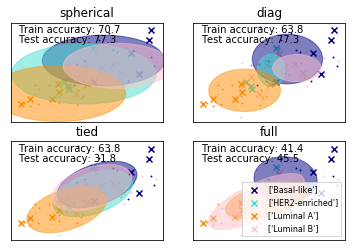

In [96]:
for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)    
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = pam_data[target == n]
        plt.scatter(data[:, 0], data[:, 1], s=0.8, color=color)
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color,label=le.inverse_transform([n]))

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)
    
    print(test_accuracy)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=8))


plt.show()

**In above plot we plotted predicted labels on both training and held out test data using a variety of GMM covariance types. We compare GMMs with spherical, diagonal, full, and tied covariance matrices.**

**On the plots, train data is shown as dots, while test data is shown as crosses.**

**Our dataset is multi-dimensional. Only the first two dimensions are shown here, and thus some points are separated in other dimensions.**

## Discussion on Gaussian Mixture Models

**We see that both Spherical and Diag covariabce type plots are providing a high testing accuracy of 77.27**

**Diag covarince plot suggests it is better able to distinguish between clusters**


## Dendogram

In [97]:
def augmented_dendrogram(*args, **kwargs):

    ddata = hierarchy.dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        for i, d in zip(ddata['icoord'], ddata['dcoord']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            plt.plot(x, y, 'ro')
            plt.annotate("%.3g" % y, (x, y), xytext=(0, -8),
                         textcoords='offset points',
                         va='top', ha='center')

    return ddata

In [98]:
from sklearn.preprocessing import scale
from scipy.cluster import hierarchy

df = processed_numerical_p50_pipeline
X = scale(df)

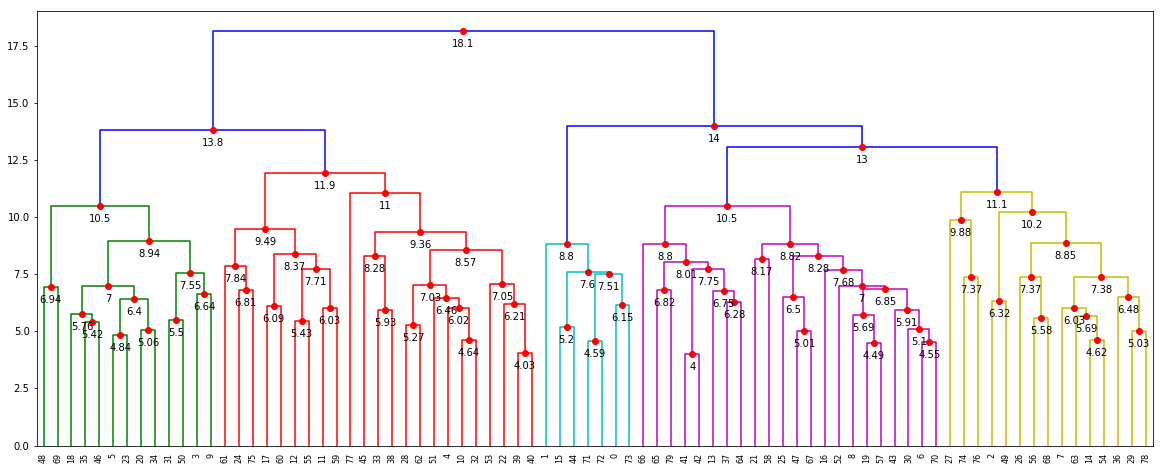

In [99]:
Z = hierarchy.linkage(X, 'complete')  #CLUSTER the data using hierarchi

plt.figure(figsize=(20,8))

#print(Z)
dn = augmented_dendrogram(Z, 
                         leaf_rotation=90.,  # rotates the x axis labels
                        leaf_font_size=8.,  # font size for the x axis labels
)

With dendogram we are able to better visualize the clusters 

In [100]:
model = AgglomerativeClustering(linkage='complete', n_clusters= 3)

In [101]:
output = model.fit_predict(X)

In [102]:
print(np.unique(output, return_counts=True))

(array([0, 1, 2], dtype=int64), array([36, 37,  7], dtype=int64))


## Using gaussian mixture models with PCA in pipeline form

In [103]:
import itertools
from sklearn import decomposition
from scipy import linalg
import matplotlib as mpl
from sklearn import mixture
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV


gmm = mixture.GaussianMixture(random_state=1, init_params='kmeans')
pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('gaussian', gmm)])



# Prediction
n_components = [3] # [1, 2, 3, 4, 5] 
covariances = ["full", "tied", "diag", "spherical"]
# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              gaussian__n_components=n_components,
                              gaussian__covariance_type=covariances))
estimator.fit(X_new)
print (estimator.best_estimator_)

Pipeline(memory=None,
     steps=[('pca', PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('gaussian', GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=1, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None))])


In [104]:
pca_mat=estimator.best_estimator_.named_steps['pca'].fit_transform(X_new)
gmm_best=estimator.best_estimator_.named_steps['gaussian'].fit(pca_mat)
subtype_predict=gmm_best.predict(pca_mat)


# Removing undetermined patients

hist_type_num=[] #Converting names to numbers with no undetermined patients
undetermined_pat_index=[]
for i in range(len(hist_cat)):
    if hist_cat[i]=="Undetermined":
      undetermined_pat_index.append(i)
    elif hist_cat[i]=="ER/PR-Positive":
      hist_type_num.append(0)
    elif hist_cat[i]=="HER2-Positive":
      hist_type_num.append(1)
    elif hist_cat[i]=="TNBC":
      hist_type_num.append(2)    
hist_type_num=np.array(hist_type_num)
undetermined_pat_index=np.array(undetermined_pat_index)


subtype_predict_noun=[] #Converting names to numbers with no undetermined patients
for i in range(len(subtype_predict)):
   ind=np.where(undetermined_pat_index==i)
   if len(ind[0])>0:
      pass
   else:
      subtype_predict_noun.append(subtype_predict[i])
 
subtype_predict_noun=np.array(subtype_predict_noun)
#print (hist_cat)
#print (hist_type_num)
#print (subtype_predict_noun)

from sklearn.metrics import accuracy_score

accuracy_score(subtype_predict_noun, hist_type_num)

0.5

From using GMM in pipeline form and GridSearchCV we achieved an accuracy of 0.5.

# Further tasks

Draw and study dendograms to further understand and identify classifications for clusters greater than 3

Use of GMM models to improve classification. Current models are base version

Use reduced number of features to classify an improve classification



# Phase 4 - Final Report

In this project, we have made use of various unsupervised learning techniques to classify patients into various subtypes of breast cancer. 

Phase 1

As first task we downloaded, loaded and analyzed the data to understand the features. Dataset has data for 80 patients and 12553 proteins for them. The data was then preprocessed by dropping columns like symbol, transposed the matrix as we wanted to classify patients and not proteins, used Imputer strategy of median to fill missing values. We define the evaluation criteria Silhouette score, Homogeneity score, Inertia to be used for unsupervised learning.

Using preprocessed data we first use KMeans to generate baseline clusters and various scores. Using inertia we judge number of clusters as 3. The heatmap plot for all patients, proteins and clusters clearly explains various clusters and we can visualize the patterns of proteins in various clusters.

We further use other algorithms like Scaler + Imputer in a Pipeline for KMeans, KMeans using random proteins, KMeans + Normalizer, AffinityPropogation, DBScan, Mini batch. The best number of clusters came out to be 3 with Silhouette and Homegeneity score as 0.1753 and 0.4125 respectively. For default Kmeans time taken to fit is 1.414 sec whereas for mini batch it is 0.070 sec. Division of patients into three clusters is as 34, 20 and 26.

Then we did an initial investigation of the accuracy of the classification using PCA. For this we defined a new metric called purity in which the median L2 coordinates of a particular breast cancer subtype (using the ground truth) was chosen as the center and the standard deviation as radius. We achieved a purity of 0.39 for the TNBC cluster, 0.82 for ER/PR-Positive cluster and 0.52 for HER2-Positive cluster.

Phase 2

Next we did hyper parameter tuning using GRID Search + 3 cross fold + KMeans and hyperparameters as number of clusters, maximum iteration, init, relative increment in results. Best number of clusters again came out to be 3 but we see a very good improvement in Homogeneity score as 0.672, Silhouette Coefficient remained the same as 0.175. Best hyperparameters generated are {'max_iter': 400, 'n_clusters': 3, 'n_init': 10, 'tol': 1e-06}.

We further use Random Search + 3 cross fold + Kmeans. Hyperparameters range is number of clusters from 2 to 6, init from 10 to 20, max iterations from 100 to 500. The best parameters came out to be {'max_iter': 390, 'n_clusters': 5, 'n_init': 18} but Silhouette Coefficient dropped significantly to 0.139.

GRID search is further used to find higher number of clusters. Best paremeters came out to be {'max_iter': 200, 'n_clusters': 7, 'n_init': 10, 'tol': 0.0001} but with very low Silhouette Coefficient of 0.094.
We then used L1 penalization to select 36 genes from a set of 6912 genes. With the 6912 genes using PCA we achieved total number of predicted clusters equal to five whereas when we used the reduced L1 penalized set, we got the expected number of clusters which is three.

Phase 3

Next we did significance of the L1 penalized test by comparing it to a known set of genes PAM50 which is known to successfully classify breast cancer subtypes. We are looking for genes which were common to both the L1 penalized dataset and PAM50 dataset. The statistical significance of the common genes was estimated by calculating the binomial p-value (presence/absence) which was found to be 6.52e-06 < 0.05. This suggests that the L1 penalization was successfully able to predict the genes which can be used for breast cancer subtype prediction.

Again we use existing dataset PAM50 that has the true values of breast cancer type for the given dataset. We use Gaussian mixture models + Imputer as median + StratifiedKFold as 4 + covariance_type as 'spherical', 'diag', 'tied', 'full'. We see that both Spherical and Diag covariabce type plots are providing a high testing accuracy of 77.27.

Phase 4

We then plot the dendogram of all patients using complete linkage. Using this we can see the division of clusters at various labels. This dendogram can be further used understand more patterns and higher clusters to find sub-types. Default AgglomerativeClustering results for the same data gives us the division of patients into three clusters as 36, 37, 7.

Conclusion:
Using unsupervised learning, best number of clusters observed are 3. Using these clusters biologists can better study common patterns and work on those patients

Using PCA, able to identify 36 most important genes which will be most suitable for identifying breast cancer subtypes


In [106]:
results

,Algorithm,n_clusters,n_init,max_iter,Silhouette Coefficient,Homogeneity score,Train Time(s)
0,K Means Default,3,10,300,0.1705,0.4021,
1,K Means Default Random protein,3,10,300,0.1066,0.0391,
2,K Means Default with time,3,10,300,0.1753,0.4125,1.819 s
3,K Means Pipeline Standard Scaler,3,10,300,0.1314,0.4346,
4,K Means Pipeline Normalizer,3,10,300,0.1554,0.3386,
5,Affinity Propogation,3,,200,0.174,0.445,
6,DBSCAN,1,,eps = 10,NA,0.000,
7,Mini Batch KMeans - Kmeans++,3,10,300,0.107,0.613,0.019 s
8,GRIDSearch CV,3,20,400,0.175329,0.701246,
9,RandomSearch CV,5,16,106,0.136653,0.736797,
